# Walk Forward Drift Adjusted Portfolio Optimization (DPO) vs. Mean-Variance Optimization

Empirical analysis of a new, novel portfolio optimization methodology created to be more robust out-of-sample: 

- Test is conducted by analyzing the efficacy of the universal DPO process vs. numerous constrained and unconstrained MVOs.
- Optimization methods are compared according to rebalancing frequency (i.e., 10, 20, & 60 trading day rebalancing frequencies).
- Optimization efficacy is determined based on: 
    - stability of performance across rebal_freqs
    - robustness to parameter tuning
    - implementability of portfolio weights
    - performance summary
- These are all implementable portfolios that exclusively use information prior to their rebalancing dates. Therefore, their outlined performance is reasonable to benchmark against each other and theoretically robust.
- One key advantage of DPO over MVO is its limited parameters and simplicity. There is no dependence on covaraince matrix estimation and inversion. 
- DPO maintains the ability to implement key constraints that portfolio managers may need (vol targeting, long-only, etc.) with the benefit of reducing the dimensionality of parameters. 

In [6]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtest_tools.portfolio_tools as pt

In [7]:
# Import Strategy Class
# from dasr_optimized_portfolio_strategy_class import dasr_optimized_portfolio
from strategy_classes.dasr_optimized_portfolio_strategy.dasr_optimized_portfolio_strategy_class import dasr_optimized_portfolio

Create Utility Functions

In [15]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
# -------------------------------------- Portfolio Optimization Functions --------------------------------------

def portfolio_dasr(w: pd.Series, returns: pd.DataFrame, neg = True) ->  float:
    """ Computes DASR of weighted portfolio.

    Args:
        betas (pd.Series): daily expected returns from normalized linear regression.
        squared_residuals (pd.DataFrame): squared error from OLS regression.
        w (pd.Series): portfolio weights.

    Returns:
        float: _description_
    """

    # Get weighted returns
    returns = (returns * w).sum(1)
    # Get weighted portfolio DASR
    portfolio_dasr = pt.drift_adjusted_sharpe_ratio(returns.dropna())

    if neg:
        # Return negative DASR for portfolio optimization
        return (-portfolio_dasr)
    
    # Return real DASR for performance analysis purposes
    return portfolio_dasr

def dpo_optimization(returns: pd.DataFrame, long_only=False, constrained=True, max_position_weight=1, vol_target=None) -> pd.Series:
    """ Executes constrained convex portfolio optimization to generate optimal
        DASR asset weights.

    Args:
        returns (pd.DataFrame): _description_
        long_only (bool, optional): _description_. Defaults to False.
        constrained (bool, optional): _description_. Defaults to True.
        max_position_weight (int, optional): _description_. Defaults to 1.
        vol_target (_type_, optional): _description_. Defaults to None.

    Returns:
        pd.Series: _description_
    """

    n = len(returns.columns)

    # Initial guess is naive 1/n portfolio
    w = np.array([1 / n] * n)

    # Declare constraints list
    constraints =  []

    # Set constraints (e.g., leverage, vol target, max sizing)
    if constrained:

        # Max position size
        if long_only:
            # Long only constraint
            bounds = Bounds(0, max_position_weight)
        else:
            # L/S constraint
            bounds = Bounds(-max_position_weight, max_position_weight)

        # constraints =  [# Weights Constraint
        #         {"type": "eq", "fun": lambda w: np.sum(np.abs(w)) - 1},
        #         # {"type": "eq", "fun": lambda w: np.sum(w) - 0},
        #         ]
        # No Leverage Constraint
        constraints.append({"type": "eq", "fun": lambda w: np.sum(np.abs(w)) - 1})

        # Volatility Targeting
        if vol_target is not None:           
            constraints.append({"type": "eq", "fun": lambda w: np.sqrt(np.dot(np.dot(w.T, returns.cov()), w)) - vol_target})
    else:
        # Is not implementable nor optimal
        bounds = Bounds(-100, 100)

        constraints =  []
    
    # Get optimized weights
    w = pd.Series(minimize(portfolio_dasr, 
                            w,
                            args=(returns), 
                            method='SLSQP',
                            bounds = bounds,
                            constraints=constraints)['x'],
                index=returns.columns
                )
    
    return w

def multistrategy_portfolio_optimization(multistrategy_portfolio: pd.DataFrame, rebal_freq: int, lookback_window: int, optimization = ['MVO', 'DPO'], vol_target=None, max_position_weight=.2, constrained=True):
    """ Executes multistrategy portfolio optimization by leveraging either one of two different optimization algorithms: 
        - MVO
        - Drift Adjusted Portfolio Optimization

    Args:
        multistrategy_portfolio (pd.DataFrame): strategy returns.
        rebal_freq (int):
        lookback_window (int): 
        optimiztion (list, optional): type of optimization. Defaults to ['MVO', 'DPO'].
        vol_target (float, optional): Defaults to .01.
        max_position_weight (float, optional): Defaults to .5.
        constrained (boolean, optiona;): 
    """

    w = {}

    if optimization == 'MVO':
        for date in multistrategy_portfolio.index[::rebal_freq]:
        
            w[date] = pt.mvo(hist_returns=multistrategy_portfolio.loc[:date], expected_returns=multistrategy_portfolio.loc[:date].tail(lookback_window).mean(), vol_target=vol_target, max_position_weight=max_position_weight, constrained=constrained, verbose=False, long_only=True)
    
    elif optimization == 'DPO':
        for date in multistrategy_portfolio.index[::rebal_freq]:
            w[date] = dpo_optimization(returns=multistrategy_portfolio.loc[:date].tail(lookback_window), long_only=True, constrained=constrained, max_position_weight=max_position_weight, vol_target=vol_target)

    # Convert Hash Table to DataFrame
    indices_df = pd.DataFrame(index=multistrategy_portfolio.index)
    w = pd.concat([indices_df, pd.DataFrame(w).T], axis=1).ffill().dropna()

    # Get strategy returns
    multistrategy_portfolio_optimized_returns = (multistrategy_portfolio*w.shift(2)).sum(1).dropna()

    return multistrategy_portfolio_optimized_returns, w

    

Visualize Individual Strategy

20
['SPY', 'QQQ', 'DBC', 'TLT', 'GLD']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.603
Drift Adjusted Sharpe Ratio                7.800
CAGR                                       0.057
Vol                                        0.100
Sortino Ratio                              0.778
Martin (Ulcer) Ratio                       0.930
Omega Ratio                                0.986
RR Ratio                                   1.125
Win Rate                                   0.522
Skew                                      -0.037
Kurtosis                                  11.171
Max Drawdown                              -0.179
VaR - Laplace                             -0.024
CVaR - Laplace                            -0.031


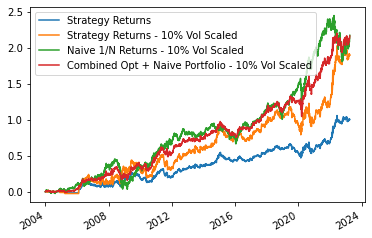

10
['SPY', 'QQQ', 'DBC', 'TLT', 'GLD']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.561
Drift Adjusted Sharpe Ratio                2.400
CAGR                                       0.052
Vol                                        0.100
Sortino Ratio                              0.774
Martin (Ulcer) Ratio                       0.524
Omega Ratio                                0.979
RR Ratio                                   1.112
Win Rate                                   0.512
Skew                                       0.161
Kurtosis                                   9.481
Max Drawdown                              -0.282
VaR - Laplace                             -0.025
CVaR - Laplace                            -0.032


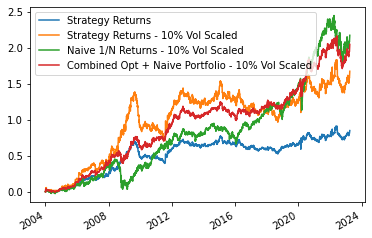

20
['SPY', 'QQQ', 'GLD', 'TLT', 'DBC', 'XLE', 'EEM']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.484
Drift Adjusted Sharpe Ratio                6.972
CAGR                                       0.044
Vol                                        0.100
Sortino Ratio                              0.667
Martin (Ulcer) Ratio                       0.622
Omega Ratio                                0.965
RR Ratio                                   1.094
Win Rate                                   0.517
Skew                                       0.121
Kurtosis                                   7.779
Max Drawdown                              -0.181
VaR - Laplace                             -0.025
CVaR - Laplace                            -0.031


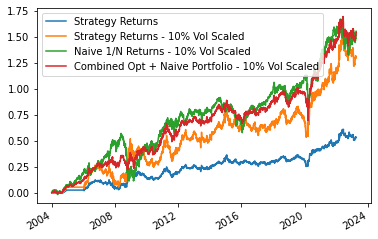

10
['SPY', 'QQQ', 'GLD', 'TLT', 'DBC', 'XLE', 'EEM']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.420
Drift Adjusted Sharpe Ratio                0.698
CAGR                                       0.037
Vol                                        0.100
Sortino Ratio                              0.576
Martin (Ulcer) Ratio                       0.293
Omega Ratio                                0.954
RR Ratio                                   1.081
Win Rate                                   0.514
Skew                                      -0.106
Kurtosis                                   9.188
Max Drawdown                              -0.283
VaR - Laplace                             -0.025
CVaR - Laplace                            -0.032


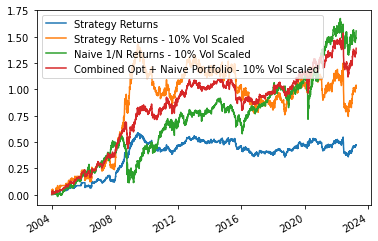

20
['SPY', 'GLD', 'TLT', 'DBC', 'JNK', 'EEM']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.470
Drift Adjusted Sharpe Ratio                4.134
CAGR                                       0.043
Vol                                        0.100
Sortino Ratio                              0.603
Martin (Ulcer) Ratio                       0.565
Omega Ratio                                0.959
RR Ratio                                   1.100
Win Rate                                   0.519
Skew                                       0.143
Kurtosis                                  15.158
Max Drawdown                              -0.251
VaR - Laplace                             -0.024
CVaR - Laplace                            -0.030


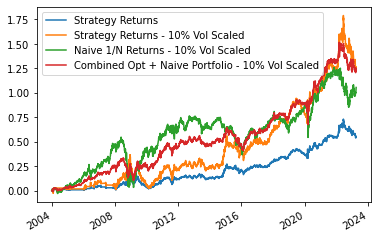

10
['SPY', 'GLD', 'TLT', 'DBC', 'JNK', 'EEM']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.759
Drift Adjusted Sharpe Ratio                1.625
CAGR                                       0.073
Vol                                        0.100
Sortino Ratio                              1.044
Martin (Ulcer) Ratio                       0.741
Omega Ratio                                1.016
RR Ratio                                   1.163
Win Rate                                   0.522
Skew                                       0.545
Kurtosis                                  12.462
Max Drawdown                              -0.215
VaR - Laplace                             -0.024
CVaR - Laplace                            -0.031


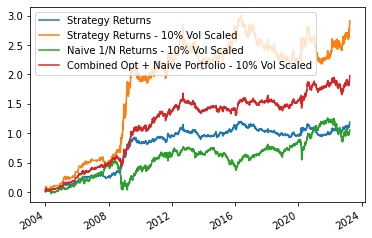

20
['SPY', 'QQQ', 'TLT', 'DBC']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.565
Drift Adjusted Sharpe Ratio                3.095
CAGR                                       0.053
Vol                                        0.100
Sortino Ratio                              0.724
Martin (Ulcer) Ratio                       0.825
Omega Ratio                                0.978
RR Ratio                                   1.120
Win Rate                                   0.521
Skew                                       0.061
Kurtosis                                  14.163
Max Drawdown                              -0.154
VaR - Laplace                             -0.025
CVaR - Laplace                            -0.030


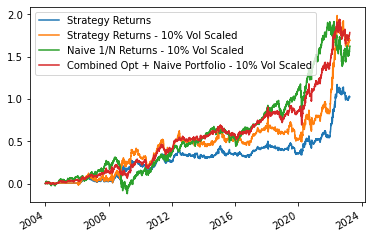

10
['SPY', 'QQQ', 'TLT', 'DBC']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.198
Drift Adjusted Sharpe Ratio                0.315
CAGR                                       0.015
Vol                                        0.100
Sortino Ratio                              0.249
Martin (Ulcer) Ratio                       0.111
Omega Ratio                                0.911
RR Ratio                                   1.039
Win Rate                                   0.513
Skew                                      -0.376
Kurtosis                                  12.237
Max Drawdown                              -0.350
VaR - Laplace                             -0.024
CVaR - Laplace                            -0.031


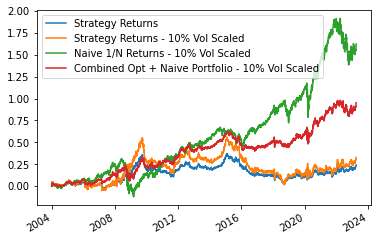

In [23]:
for i in range(0, 8):

    path = fr'C:\Users\marcu\Documents\Quant\Programming\Strategies\Beta Strategies\dasr_optimized_portfolio_strategy_{i}.pickle'
    
    with open(path, 'rb') as handler:
        strategy = pickle.load(handler)
        print(strategy.rebal_freq)
        strategy.performance_analysis()
        print(strategy.strategy_performance_summary)
        plt.show()

20
['SPY', 'QQQ', 'DBC', 'TLT', 'GLD']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.603
Drift Adjusted Sharpe Ratio                7.800
CAGR                                       0.057
Vol                                        0.100
Sortino Ratio                              0.778
Martin (Ulcer) Ratio                       0.930
Omega Ratio                                0.986
RR Ratio                                   1.125
Win Rate                                   0.522
Skew                                      -0.037
Kurtosis                                  11.171
Max Drawdown                              -0.179
VaR - Laplace                             -0.024
CVaR - Laplace                            -0.030


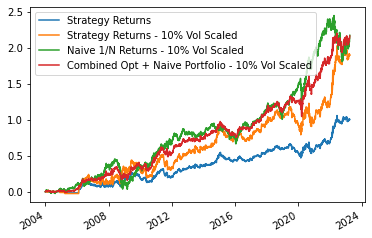

10
['SPY', 'QQQ', 'DBC', 'TLT', 'GLD']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.561
Drift Adjusted Sharpe Ratio                2.400
CAGR                                       0.052
Vol                                        0.100
Sortino Ratio                              0.774
Martin (Ulcer) Ratio                       0.524
Omega Ratio                                0.979
RR Ratio                                   1.112
Win Rate                                   0.512
Skew                                       0.161
Kurtosis                                   9.481
Max Drawdown                              -0.282
VaR - Laplace                             -0.024
CVaR - Laplace                            -0.031


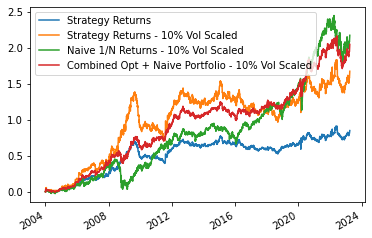

20
['SPY', 'QQQ', 'GLD', 'TLT', 'DBC', 'XLE', 'EEM']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.484
Drift Adjusted Sharpe Ratio                6.972
CAGR                                       0.044
Vol                                        0.100
Sortino Ratio                              0.667
Martin (Ulcer) Ratio                       0.622
Omega Ratio                                0.965
RR Ratio                                   1.094
Win Rate                                   0.517
Skew                                       0.121
Kurtosis                                   7.779
Max Drawdown                              -0.181
VaR - Laplace                             -0.025
CVaR - Laplace                            -0.032


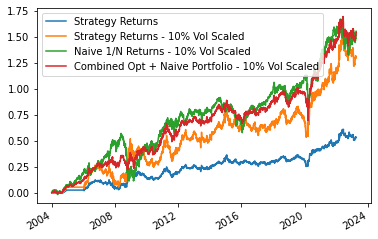

10
['SPY', 'QQQ', 'GLD', 'TLT', 'DBC', 'XLE', 'EEM']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.505
Drift Adjusted Sharpe Ratio                0.868
CAGR                                       0.046
Vol                                        0.100
Sortino Ratio                              0.717
Martin (Ulcer) Ratio                       0.449
Omega Ratio                                0.970
RR Ratio                                   1.095
Win Rate                                   0.511
Skew                                      -0.043
Kurtosis                                   8.540
Max Drawdown                              -0.223
VaR - Laplace                             -0.025
CVaR - Laplace                            -0.032


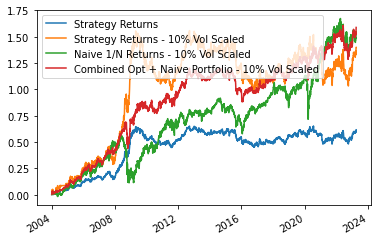

20
['SPY', 'GLD', 'TLT', 'DBC', 'JNK', 'EEM']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.430
Drift Adjusted Sharpe Ratio                4.466
CAGR                                       0.039
Vol                                        0.100
Sortino Ratio                              0.562
Martin (Ulcer) Ratio                       0.506
Omega Ratio                                0.953
RR Ratio                                   1.087
Win Rate                                   0.520
Skew                                       0.088
Kurtosis                                  13.761
Max Drawdown                              -0.244
VaR - Laplace                             -0.024
CVaR - Laplace                            -0.031


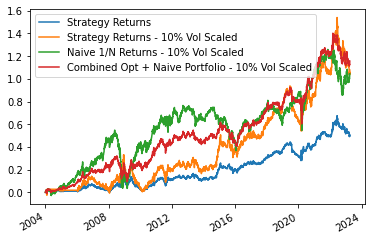

10
['SPY', 'GLD', 'TLT', 'DBC', 'JNK', 'EEM']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.713
Drift Adjusted Sharpe Ratio                1.711
CAGR                                       0.068
Vol                                        0.100
Sortino Ratio                              1.002
Martin (Ulcer) Ratio                       0.745
Omega Ratio                                1.007
RR Ratio                                   1.147
Win Rate                                   0.519
Skew                                       0.575
Kurtosis                                  11.985
Max Drawdown                              -0.217
VaR - Laplace                             -0.024
CVaR - Laplace                            -0.031


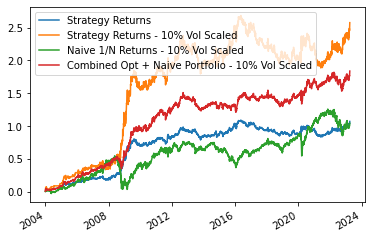

20
['SPY', 'QQQ', 'TLT', 'DBC']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.533
Drift Adjusted Sharpe Ratio                4.222
CAGR                                       0.049
Vol                                        0.100
Sortino Ratio                              0.695
Martin (Ulcer) Ratio                       0.814
Omega Ratio                                0.973
RR Ratio                                   1.107
Win Rate                                   0.521
Skew                                      -0.096
Kurtosis                                  10.816
Max Drawdown                              -0.212
VaR - Laplace                             -0.024
CVaR - Laplace                            -0.030


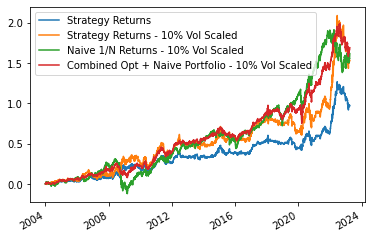

10
['SPY', 'QQQ', 'TLT', 'DBC']
                             Performance Summary
Strategy Returns                                
Sharpe Ratio                               0.300
Drift Adjusted Sharpe Ratio                0.369
CAGR                                       0.025
Vol                                        0.100
Sortino Ratio                              0.392
Martin (Ulcer) Ratio                       0.183
Omega Ratio                                0.931
RR Ratio                                   1.059
Win Rate                                   0.512
Skew                                      -0.158
Kurtosis                                  10.757
Max Drawdown                              -0.343
VaR - Laplace                             -0.025
CVaR - Laplace                            -0.032


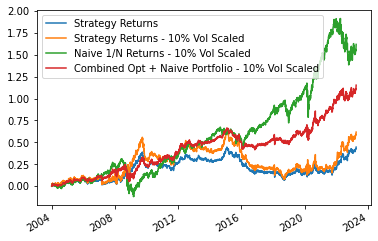

In [22]:
for i in range(0, 8):

    path = fr'C:\Users\marcu\Documents\Quant\Programming\Strategies\Beta Strategies\dasr_optimized_portfolio_strategy_{i}.pickle'
    
    with open(path, 'rb') as handler:
        strategy = pickle.load(handler)
        print(strategy.rebal_freq)
        strategy.performance_analysis()
        print(strategy.strategy_performance_summary)
        plt.show()

# Create Multistrategy Portfolio

In [10]:
multistrategy_portfolio = {}

for i in range(0, 7):

    path = fr'C:\Users\marcu\Documents\Quant\Programming\Strategies\Beta Strategies\dasr_optimized_portfolio_strategy_{i}.pickle'
    
    with open(path, 'rb') as handler:
        strategy = pickle.load(handler)
        multistrategy_portfolio[i] = strategy.strategy_returns

    i+=1

multistrategy_portfolio = pd.DataFrame(multistrategy_portfolio)

In [11]:
import datetime as dt

# Isolate portfolio returns post-2004
multistrategy_portfolio = multistrategy_portfolio.loc[dt.date(2004, 1, 1):]

# Walk Forward Drift Adjusted Portfolio Optimization (DPO) vs. Mean-Variance Optimization

- Test is conducted by analyzing the efficacy of the universal DPO process vs. numerous constrained and unconstrained MVOs.
- Optimization methods are compared according to rebalancing frequency (i.e., 10, 20, & 60 trading day rebalancing frequencies).
- Optimization efficacy is determined based on: 
    - stability of performance across rebal_freqs
    - robustness to parameter tuning
    - implementability of portfolio weights
    - performance summary
- These are all implementable portfolios that exclusively use information prior to their rebalancing dates. Therefore, their outlined performance is reasonable to benchmark against each other and theoretically robust.

In [37]:
rebal_freq = 10
lookback_window = 10
multistrategy_portfolio_dpo, dpo_w = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimization = 'DPO', max_position_weight=1)
print('DPO 1 DONE')

DPO 1 DONE


,Performance Summary
Sharpe Ratio,0.823
Drift Adjusted Sharpe Ratio,13.361
CAGR,0.080
Vol,0.100
Sortino Ratio,1.094
Martin (Ulcer) Ratio,1.410
Omega Ratio,1.027
RR Ratio,1.165
Win Rate,0.527
Skew,-0.166


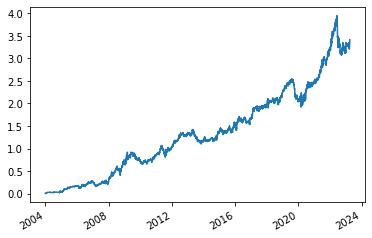

In [38]:
pt.cumulative_returns(pt.scale_vol(multistrategy_portfolio_dpo)).plot()
pt.performance_summary(pt.scale_vol(multistrategy_portfolio_dpo))

In [95]:
# Create optimizations for 20 day rebal
rebal_freq = 20
lookback_window = 20
multistrategy_portfolio_dpo_1, dpo_w_1 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'DPO')
print('DPO 1 DONE')
multistrategy_portfolio_mvo_1, mvo_w_1 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=.5)
multistrategy_portfolio_mvo_2, mvo_w_2 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=3)
multistrategy_portfolio_mvo_3, mvo_w_3 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=.5)
multistrategy_portfolio_mvo_4, mvo_w_4 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=3)
multistrategy_portfolio_mvo_uncon_1, mvo_w_uncon_1 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', constrained=False)

# Create optimizations for 10 day rebal
rebal_freq = 10
lookback_window = 10
multistrategy_portfolio_dpo_2, dpo_w_2 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'DPO')
print('DPO 2 DONE')
multistrategy_portfolio_mvo_5, mvo_w_5 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=.5)
multistrategy_portfolio_mvo_6, mvo_w_6 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=3)
multistrategy_portfolio_mvo_7, mvo_w_7 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=.5)
multistrategy_portfolio_mvo_8, mvo_w_8 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=3)
multistrategy_portfolio_mvo_uncon_2, mvo_w_uncon_2 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', constrained=False)

# Create optimizations for 60 day rebal
rebal_freq = 60
lookback_window = 60
multistrategy_portfolio_dpo_3, dpo_w_3 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'DPO')
print('DPO 3 DONE')
multistrategy_portfolio_mvo_9, mvo_w_9 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=.5)
multistrategy_portfolio_mvo_10, mvo_w_10 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=3)
multistrategy_portfolio_mvo_11, mvo_w_11 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=.5)
multistrategy_portfolio_mvo_12, mvo_w_12 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.1, max_position_weight=3)
multistrategy_portfolio_mvo_uncon_3, mvo_w_uncon_3 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', constrained=False)               

DPO 1 DONE


C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(

DPO 2 DONE


C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(

DPO 3 DONE


C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pandas\core\frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(

Cateogrize Optimization Methods' Returns 

In [56]:
dpo = [multistrategy_portfolio_dpo_1, multistrategy_portfolio_dpo_2, multistrategy_portfolio_dpo_3]
mvo = [multistrategy_portfolio_mvo_1, multistrategy_portfolio_mvo_2, multistrategy_portfolio_mvo_3, multistrategy_portfolio_mvo_4, multistrategy_portfolio_mvo_5, multistrategy_portfolio_mvo_6, multistrategy_portfolio_mvo_7, 
       multistrategy_portfolio_mvo_8, multistrategy_portfolio_mvo_9, multistrategy_portfolio_mvo_10, multistrategy_portfolio_mvo_11, multistrategy_portfolio_mvo_12]
uncon_mvo = [multistrategy_portfolio_mvo_uncon_1, multistrategy_portfolio_mvo_uncon_2, multistrategy_portfolio_mvo_uncon_2]

Compute Performance Metrics and Benchmark

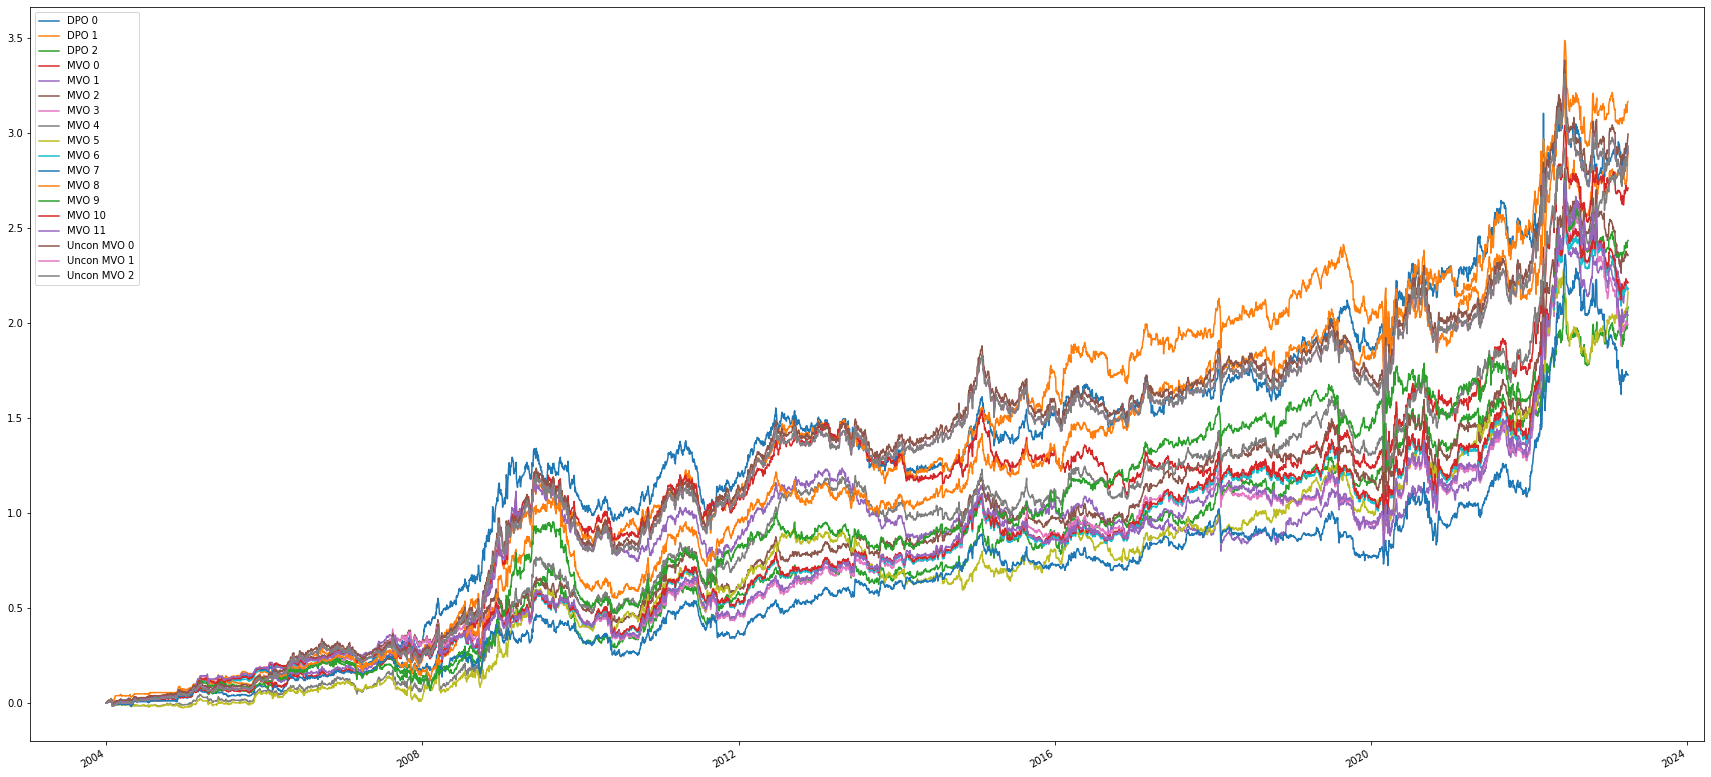

In [92]:
plt.figure(figsize=(30, 15))

# Drift Adjusted Portfolio Optimization
dpo_performance = pd.DataFrame()

for i, p_rets in enumerate(dpo):
    # Scale returns
    tmp_rets = pt.scale_vol(p_rets)
    # Plot cumulative returns
    pt.cumulative_returns(tmp_rets).plot(label=f'DPO {i}', legend=True)
    # Add strategy to DPO pd.DataFrame
    dpo_performance = pd.concat([pt.performance_summary(tmp_rets), dpo_performance], axis=1)

# Compute average performance metrics across optimization implementations
dpo_performance = dpo_performance.mean(axis=1)

# Constrained MVO
mvo_performance = pd.DataFrame()

for i, p_rets in enumerate(mvo):
    # Scale returns
    tmp_rets = pt.scale_vol(p_rets)
    # Plot cumulative returns
    pt.cumulative_returns(tmp_rets).plot(label=f'MVO {i}', legend=True)
    # Add strategy to DPO pd.DataFrame
    mvo_performance = pd.concat([pt.performance_summary(tmp_rets), mvo_performance], axis=1)

# Compute average performance metrics across optimization implementations
mvo_performance = mvo_performance.mean(axis=1)

# Unconstrained MVO (never implementable)
uncon_mvo_performance = pd.DataFrame()

for i, p_rets in enumerate(uncon_mvo):
    # Scale returns
    tmp_rets = pt.scale_vol(p_rets)
    # Plot cumulative returns
    pt.cumulative_returns(tmp_rets).plot(label=f'Uncon MVO {i}', legend=True)
    # Add strategy to DPO pd.DataFrame
    uncon_mvo_performance = pd.concat([pt.performance_summary(tmp_rets), uncon_mvo_performance], axis=1)
    
# Compute average performance metrics across optimization implementations
uncon_mvo_performance = uncon_mvo_performance.mean(axis=1)

In [93]:
# Get comparative performance
average_optimization_performance = pd.concat([dpo_performance, mvo_performance, uncon_mvo_performance], axis=1)
average_optimization_performance.columns = ['DPO', 'MVO', 'Uncon MVO']
average_optimization_performance

,DPO,MVO,Uncon MVO
Sharpe Ratio,0.717333,0.673833,0.764667
Drift Adjusted Sharpe Ratio,14.483667,6.562750,11.037667
CAGR,0.068667,0.064583,0.074333
Vol,0.100000,0.100000,0.100000
Sortino Ratio,0.967000,0.885083,1.035667
Martin (Ulcer) Ratio,1.164333,1.028417,1.105667
Omega Ratio,1.007333,0.999417,1.016333
RR Ratio,1.141667,1.137000,1.150667
Win Rate,0.527667,0.527250,0.531000
Skew,-0.069667,-0.057417,-0.027333
